## Distribution of gradient norms with and without normalization 

This notebook plots the distribution of the norms of the gradients of a multi channel convolutional neural network with and without channel normalization. 

In [5]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include.multi_channel import *
from include import *
from PIL import Image
import PIL

import torch
import torch.optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.linalg import circulant

GPU = False
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


In [2]:
def tikz_hist(res,bins=100,filename="data.csv"):
    hist = plt.hist(res,normed=True, bins=bins)
    plt.show()
    x = np.array([ (hist[1][i] + hist[1][i+1])/2 for i in range(bins) ])
    y = np.array(hist[0])
    np.savetxt(filename, np.vstack([ x , y ]).T , delimiter="\t")

In [3]:
def init_normal(m, n = 256):
    if type(m) == nn.Conv1d:
        nn.init.normal_(m.weight,0,np.sqrt(1/64))

def grad_eval(net, y, net_input, LR = 0.05):
    p = [x for x in net.parameters()]
    # optimizer = torch.optim.SGD(p, lr=LR,momentum=0)
    mse = torch.nn.MSELoss()

    nconvnets = 0
    for p in list(filter(lambda p: len(p.data.shape)>2, net.parameters())):
        nconvnets += 1

    out = net(net_input.type(dtype))

    # training loss 
    loss = mse(out, y)
    loss.backward()
    mse_wrt_noisy = loss.data.cpu().numpy()

    # output gradients
    out_grads = np.zeros(nconvnets)
    for ind,p in enumerate(list(filter(lambda p: p.grad is not None and len(p.data.shape)>2, net.parameters()))):
        # print(p.shape)
        out_grads[ind] = p.grad.data.norm(2).item()**2

    overall_grads = np.sqrt(sum(out_grads))
    return overall_grads  

### Generate Signals

In [6]:
n = 256

# noise
shape = [1,1,n]
y = Variable(torch.zeros(shape),requires_grad=False).type(dtype)
y.data.uniform_()
y_np = y.data.cpu().numpy()[0,0]

# step function
ystep_np = np.zeros([1,n])
ystep_np[0,:int(n/2)] = np.ones(int(n/2))
ystep = np_to_var(ystep_np).type(dtype)
ystep_np = ystep_np[0]
print(ystep.shape)

# shape = [1,4,n]
# print("input shape: ", shape)
# net_input = Variable(torch.ones(shape)).type(dtype)
# net_input.data.uniform_()

torch.Size([1, 1, 256])


### num_channels =  4, network depth = 6, with channel normalization

In [8]:
num_channels = [4]*6

num_iter = 2000
para_grad_linear = np.zeros(num_iter)

for i in range(num_iter):
    shape = [1,4,n]
    net_input = Variable(torch.ones(shape)).type(dtype)
    net_input.data.uniform_()
    net_input = net_input.type(dtype)

    net = decnet(1,num_channels,9,act_fun=nn.ReLU(),mode="non-learned",res=False).type(dtype)
    net.apply(init_normal)

    para_grad_linear[i] = grad_eval(net, y=ystep, net_input=net_input)

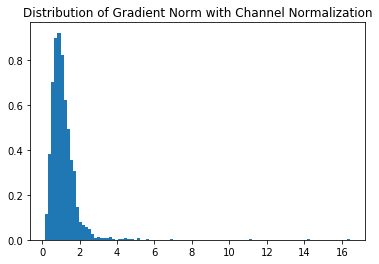

In [9]:
plt.hist(para_grad_linear, normed=True, bins=100)
plt.title('Distribution of Gradient Norm with Channel Normalization')
plt.show()

### num_channels =  4, network depth = 6, without normalization

In [10]:
num_channels = [4]*6

num_iter = 2000
para_grad_linear = np.zeros(num_iter)

for i in range(num_iter):
    shape = [1,4,n]
    net_input = Variable(torch.ones(shape)).type(dtype)
    net_input.data.uniform_()
    net_input = net_input.type(dtype)

    net = decnet(1,num_channels,9,act_fun=nn.ReLU(),mode="linear",res=False).type(dtype)
    net.apply(init_normal)

    para_grad_linear[i] = grad_eval(net, y=ystep, net_input=net_input)

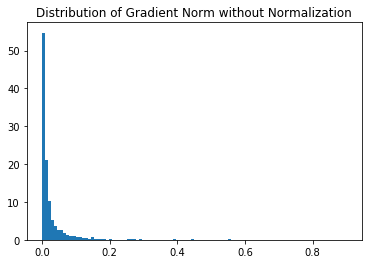

In [11]:
plt.hist(para_grad_linear, normed=True, bins=100)
plt.title('Distribution of Gradient Norm without Normalization')
plt.show()